In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy import signal as sp_signal
from tqdm import tqdm
import numpy.matlib

In [2]:
# ##
# #   COURSE: Neural signal processing and analysis: Zero to hero
# #  SESSION: Time-frequency analysis: Problem set
# #  TEACHER: Mike X Cohen, sincxpress.com
# #

## 1) Power and phase from the famous "trial 10"

Create a family of complex Morlet wavelets that range from 10 Hz to 100 Hz in 43 linearly spaced steps. 

Perform convolution between the wavelets and V1 data from trial 10 for all channels.

Extract power and phase, store the results in a channel X frequency X time X pow/phs (thus, 4D) matrix.

In [3]:
eeg_data = loadmat('../data/v1_laminar.mat', squeeze_me=True)
eeg_data['csd'].shape

(16, 1527, 200)

In [4]:
# soft-coded parameters
freqrange = [10, 100] # extract only these frequencies (in Hz)
numfrex = 43 # number of frequencies between lowest and highest
whichTrial = 9

In [5]:
# set up convolution parameters
wavtime = np.arange(-2, 2-1/eeg_data['srate'], 1/eeg_data['srate'])
frex = np.linspace(freqrange[0], freqrange[1], numfrex)
nData = len(eeg_data['timevec'])
nKern = len(wavtime)
nConv = nData + nKern - 1
halfwav = int((len(wavtime)-1)/2)

# number of cycles
numcyc = np.linspace(3, 15, numfrex);

In [24]:
# create wavelets
cmwX = np.zeros((numfrex,nConv)) + 0j

for i in range(len(frex)):
    
    # create time-domain wavelet
    twoSsquared = 2 * (numcyc[i]/(2*np.pi*frex[i])) ** 2
    cmw = np.exp(2*1j*np.pi*frex[i]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )
    
    # compute fourier coefficients of wavelet and normalize
    cmwX[i] = fft(cmw, nConv)
    cmwX[i] = cmwX[i] / np.max(cmwX[i])

In [32]:
# initialize time-frequency output matrix
tf = np.zeros((eeg_data['csd'].shape[0], numfrex, len(eeg_data['timevec']), 2))
tf.shape

(16, 43, 1527, 2)

In [63]:
# loop over channels
for chani in range(eeg_data['csd'].shape[0]):
    
    # compute Fourier coefficients of EEG data (doesn't change over frequency!)
    eegX = fft(eeg_data['csd'][chani, :, whichTrial], nConv)
    
    # loop over frequencies
    for fi in range(numfrex):
        
        # second and third steps of convolution
        a = ifft(cmwX[fi]*eegX, nConv)
        # cut wavelet back to size of data
        a = a[halfwav:-halfwav]
        
        # extract power and phase
        tf[chani,fi,:,0] = np.abs(a) ** 2
        tf[chani,fi,:,1] = np.angle(a)

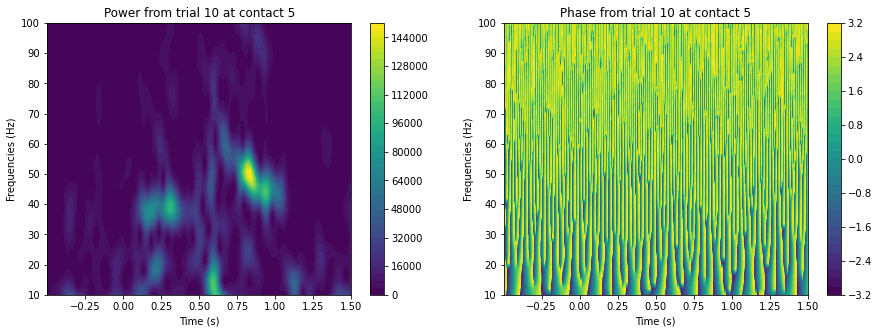

In [65]:
## plotting the results, part 1: time-frequency
# In a 1x2 subplot figure, plot time-frequency power (left) and phase (right) from electrode 6.
# use x-axis scaling of -200 to +1000 ms.

chan2plot = 5

plt.figure(figsize=(15,5))
plt.subplot(121)
# contourf(timevec,frex,squeeze(tf(chan2plot,:,:,1)),40,'linecolor','none')
plt.contourf(eeg_data['timevec'], frex, tf[chan2plot, :, :, 0], 40)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title(f'Power from trial 10 at contact {chan2plot}')
plt.colorbar()
# plt.xlim([-.2, 1])
# plt.ylim([0, 80000])

plt.subplot(122)
plt.contourf(eeg_data['timevec'], frex, tf[chan2plot, :, :, 1], 40)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title(f'Phase from trial 10 at contact {chan2plot}')
plt.colorbar()
# contourf(timevec,frex,squeeze(tf(chan2plot,:,:,2)),40,'linecolor','none')
# xlabel('Time (s)'), ylabel('Frequencies (Hz)'), title([ 'Phase from trial 10 at contact ' num2str(chan2plot) ])
# set(gca,'xlim',[-.2 1],'clim',[-pi pi])

plt.show()

In [ ]:
### QUESTION: Can you use the same color scaling for the two plots? Why or why not?
# No, because of the different range?

In [124]:
## plotting the results, part 1: Depth-by-time
# Make four layer-by-time maps in a 2x2 subplot figure. Plot power (top row) and phase (bottom row),
# from data at 40 Hz and at 55 Hz. Are there differences between power and phase, and would you expect to see 
# differences or similarities?

hzs = [np.NaN, np.NaN]
hzs[0] = np.argmin(abs(frex-40))
hzs[1] = np.argmin(abs(frex-55))
hzs

[14, 21]

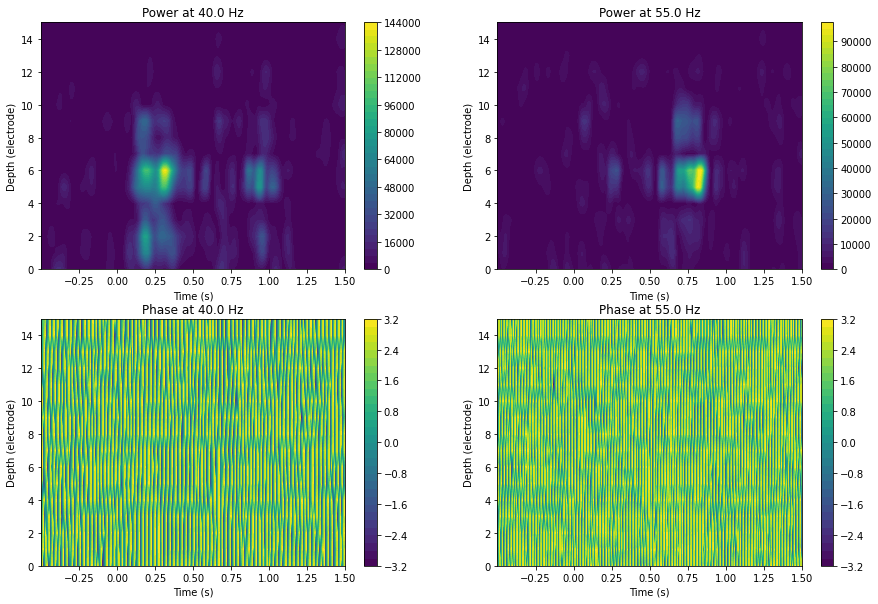

In [66]:
plt.figure(figsize=(15,10))
for i in range(2):    
    plt.subplot(2,2,i+1)
    plt.contourf(eeg_data['timevec'], 
                 np.arange(eeg_data['csd'].shape[0]), 
                 tf[:, hzs[i], :, 0],
                 40)
    plt.colorbar()
    plt.title(f'Power at {frex[hzs[i]]} Hz')
#     plt.clim([0, 40000])
    plt.xlabel('Time (s)')
    plt.ylabel('Depth (electrode)')
    
    plt.subplot(2,2,i+3)
    plt.contourf(eeg_data['timevec'], 
                 np.arange(eeg_data['csd'].shape[0]), 
                 tf[:, hzs[i], :, 1],
                 40)
    plt.colorbar()
    plt.title(f'Phase at {frex[hzs[i]]} Hz')
#     plt.clim([-np.pi, np.pi])
    plt.xlabel('Time (s)')
    plt.ylabel('Depth (electrode)')

In [ ]:
### QUESTION: How can you interpret the phase plots?
# 
# 
### QUESTION: How do you interpret the two power plots?
# 

### 1.2) Convolution with all trials

Repeat the previous exercise, but using data from all trials. Don't save the single-trial data.

Instead of the raw phases, compute ITPC. 

Generate the same plots as in #2.

QUESTION: Which parameters/variables do you need to recompute, and which can you reuse from above?

In [46]:
# set up convolution parameters
nData = len(eeg_data['timevec']) * eeg_data['csd'].shape[2]
nKern = len(wavtime)
nConv = nData + nKern - 1

In [49]:
# create wavelets
cmwX = np.zeros((numfrex,nConv)) + 0j

for i in tqdm(range(numfrex)):
    
    # create time-domain wavelet
    twoSsquared = 2 * (numcyc[i]/(2*np.pi*frex[i])) ** 2
    cmw = np.exp(2*1j*np.pi*frex[i]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )
    
    # compute fourier coefficients of wavelet and normalize
    cmwX[i] = fft(cmw, nConv)
    cmwX[i] = cmwX[i] / np.max(cmwX[i])

100%|██████████| 43/43 [00:03<00:00, 12.14it/s]


In [104]:
tf = np.zeros((eeg_data['csd'].shape[0], numfrex, len(eeg_data['timevec']), 2))
tf.shape

(16, 43, 1527, 2)

In [102]:
eegX = fft(eeg_data['csd'].reshape(eeg_data['csd'].shape[0],-1, order='F'), n=nConv)
eegX.shape

(16, 308450)

In [120]:
# loop over frequencies
for fi in tqdm(range(numfrex)):
    
    # second and third steps of convolution
    a = ifft(eegX * np.matlib.repmat(cmwX[fi], eeg_data['csd'].shape[0], 1), nConv, 1)
    
    # cut wavelet back to size of data    
    a = a[:, halfwav:-halfwav]
    
    # reshape back to original data size
    a = a.reshape(eeg_data['csd'].shape, order='F')

    # extract power and phase
    tf[:,fi,:,0] = np.mean( np.abs(a) ** 2 , 2)
    tf[:,fi,:,1] = np.abs( np.mean( np.exp(1j*np.angle(a)), 2) )

100%|██████████| 43/43 [02:26<00:00,  3.40s/it]


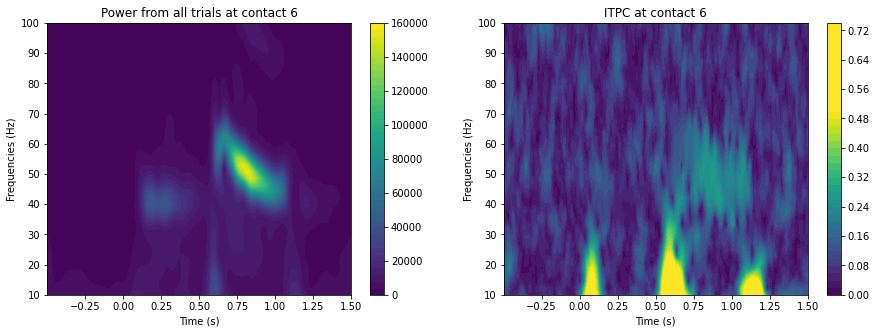

In [122]:
chan2plot = 6

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.contourf(eeg_data['timevec'], frex, tf[chan2plot, :, :, 0], 40)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title(f'Power from all trials at contact {chan2plot}')
plt.colorbar()
# plt.xlim([-.2, 1])
# plt.clim([0, 80000])

plt.subplot(122)
plt.contourf(eeg_data['timevec'], frex, tf[chan2plot, :, :, 1], 40)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title(f'ITPC at contact {chan2plot}')
plt.colorbar()
# plt.xlim([-.2, 1])
plt.clim([0, .5])

plt.show()

In [ ]:
hzs = [np.NaN, np.NaN]
hzs[0] = np.argmin(abs(frex-40))
hzs[1] = np.argmin(abs(frex-55))
hzs

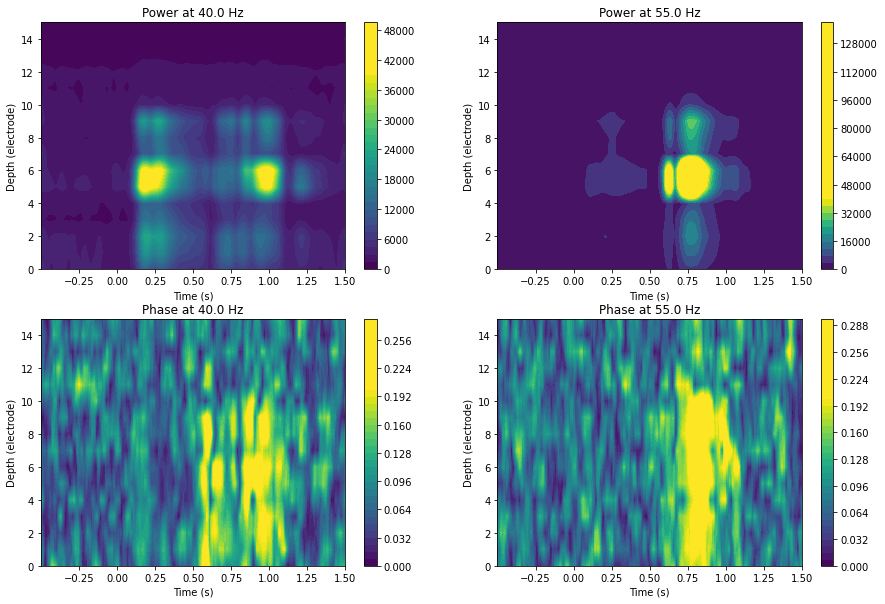

In [128]:
plt.figure(figsize=(15,10))
for i in range(2):    
    plt.subplot(2,2,i+1)
    plt.contourf(eeg_data['timevec'], 
                 np.arange(eeg_data['csd'].shape[0]), 
                 tf[:, hzs[i], :, 0],
                 40)
    plt.colorbar()
    plt.title(f'Power at {frex[hzs[i]]} Hz')
    plt.clim([0, 40000])
    plt.xlabel('Time (s)')
    plt.ylabel('Depth (electrode)')
    
    plt.subplot(2,2,i+3)
    plt.contourf(eeg_data['timevec'], 
                 np.arange(eeg_data['csd'].shape[0]), 
                 tf[:, hzs[i], :, 1],
                 40)
    plt.colorbar()
    plt.title(f'Phase at {frex[hzs[i]]} Hz')
    plt.clim([0, 0.2])
    plt.xlabel('Time (s)')
    plt.ylabel('Depth (electrode)')

## 2) Exploring edge effects

Create a square-wave time series and perform a time-frequency analysis, in order to explore the effects of edges on TF responses.

In [222]:
srate = 999
npnts = srate*1
time = np.arange(npnts)/srate

In [223]:
# create the square wave function
squarets = np.zeros(npnts)

In [224]:
squarets[np.arange(npnts*.4, npnts*.6).round().astype(int)] = 1

In [225]:
## time-frequency analysis

# soft-coded parameters
freqrange = [1, 100] # extract only these frequencies (in Hz)
numfrex = 83 # number of frequencies between lowest and highest

In [226]:
# set up convolution parameters
wavtime = np.arange(-2, 2, 1/srate)
frex = np.linspace(freqrange[0], freqrange[1], numfrex)
nKern = len(wavtime)
nConv = npnts + nKern - 1
halfwav = int(round((len(wavtime)-1)/2))

# number of cycles
numcyc = np.linspace(3,15,numfrex)

In [227]:
# compute Fourier coefficients of signal
impfunX = fft( squarets ,nConv)

# initialize TF matrix
tf = np.zeros((numfrex,npnts,2))

In [239]:
# create wavelets and do TF decomposition in one loop
for i in tqdm(range(numfrex)):
    
    # create time-domain wavelet
    twoSsquared = 2 * (numcyc[i]/(2*np.pi*frex[i])) ** 2
    cmw = np.exp(2*1j*np.pi*frex[i]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )
    
    # compute fourier coefficients of wavelet and normalize
    cmwX = fft(cmw, nConv)
    cmwX = cmwX / np.max(cmwX)
    
    # second and third steps of convolution
    a = ifft(impfunX * cmwX, nConv)
    
    # cut wavelet back to size of data    
    a = a[halfwav-1:-halfwav]
    
    # extract power and phase
    tf[i,:,0] = np.abs(a)**2
    tf[i,:,1] = np.angle(a)

100%|██████████| 83/83 [00:00<00:00, 449.00it/s]


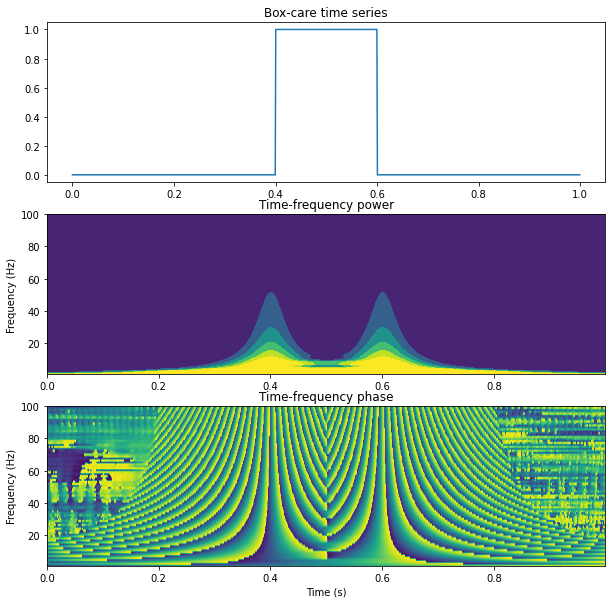

In [258]:
# plot it
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.plot(time, squarets)
plt.title('Box-care time series')

plt.subplot(312)
plt.contourf(time,frex,tf[:,:,0],40)
plt.clim([0, 0.01])
plt.title('Time-frequency power')
plt.ylabel('Frequency (Hz)')
# plt.colorbar()

plt.subplot(313)
plt.contourf(time,frex,tf[:,:,1],40)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Time-frequency phase')
# plt.colorbar()

plt.show()

## 3) Improving the spectral precision of wavelet convolution.

Remember from the first section of the course that we identified a "failure scenario" in which wavelet convolution failed to identify two sine waves that were simulated and clearly visible in the static spectrum. Let's revisit that example.

In [26]:
srate = 300
time = np.arange(srate*2)/srate

In [27]:
# create the signal with 4 and 6 Hz components
signal = np.sin(2*np.pi*4*time) + np.sin(2*np.pi*6*time)

In [30]:
# compute static power spectrum
powr = np.abs(fft(signal)/len(time)) ** 2
hz = np.linspace(0,srate,len(time))

In [31]:
## time-frequency analysis

# soft-coded parameters
freqrange = [2, 12] # extract only these frequencies (in Hz)
numfrex = 20 # number of frequencies between lowest and highest

In [54]:
# set up convolution parameters
wavtime = np.arange(-2, 2, 1/srate)
frex = np.linspace(freqrange[0],freqrange[1],numfrex)
nKern = len(wavtime)
nConv = len(time) + nKern - 1
halfwav = int(round((len(wavtime)-1)/2))

# number of cycles
fwhms = np.linspace(.5,2,numfrex)

In [55]:
# compute Fourier coefficients of signal
impfunX = fft(signal, nConv)

# initialize TF matrix
tf = np.zeros((numfrex,len(signal)))

In [56]:
# create wavelets and do TF decomposition in one loop
for fi in tqdm(range(numfrex)):
    
    # create time-domain wavelet (use the FWHM formula)
    cmw = np.exp(-4*np.log(2)*wavtime**2/fwhms[fi]**2) * np.exp(2*1j*np.pi*frex[fi]*wavtime)
    
    # compute fourier coefficients of wavelet and normalize
    cmwX = fft(cmw,nConv)
    
    # second and third steps of convolution
    a = ifft(cmwX*impfunX / np.max(cmwX), nConv )
    
    # cut wavelet back to size of data
    a = a[halfwav-1:-halfwav]
    
    # extract power
    tf[fi,:] = np.abs(a) ** 2

100%|██████████| 20/20 [00:00<00:00, 1006.70it/s]


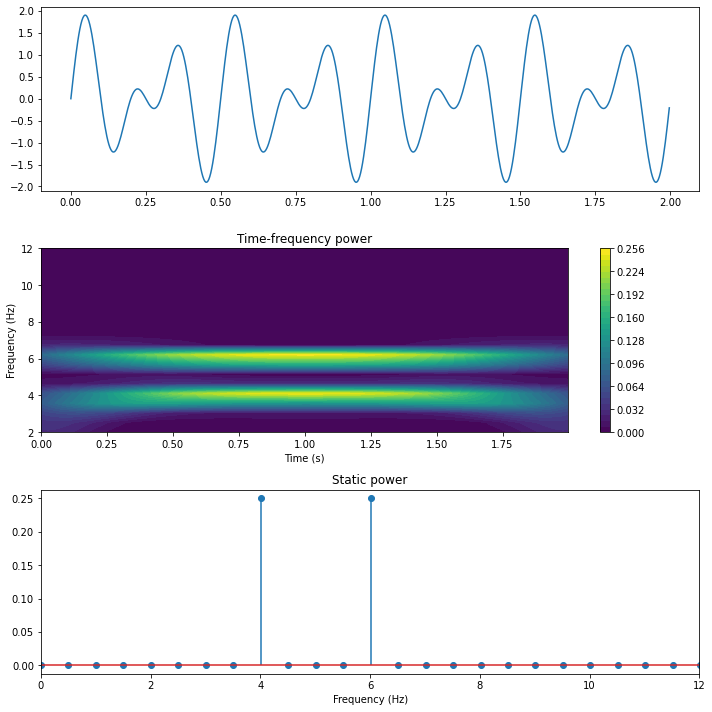

In [57]:
plt.figure(figsize=(10,10))

# plot time-domain signal
plt.subplot(311)
plt.plot(time,signal)

# plot time-frequency plot
plt.subplot(3,1,2)
plt.contourf(time,frex,tf,40)
# plt.clim([0, .2])
plt.colorbar()
plt.title('Time-frequency power')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

# plot static power spectrum
plt.subplot(3,1,3)
plt.stem(hz,powr, use_line_collection=True)
plt.xlim([0, freqrange[1]])
plt.title('Static power')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

## 4) Compare complex wavelet convolution with filter-Hilbert.

The goal here is to illustrate that complex Morlet wavelet convolution can give the same or different results as filter-Hilbert, depending on parameters.

In [102]:
eeg_data = loadmat('../data/v1_laminar.mat', squeeze_me=True)
eeg_data['csd'].shape

(16, 1527, 200)

In [103]:
# Compute the ERP from channel 7 in the v1 dataset
erp = np.mean(eeg_data['csd'][6,:,:],1)

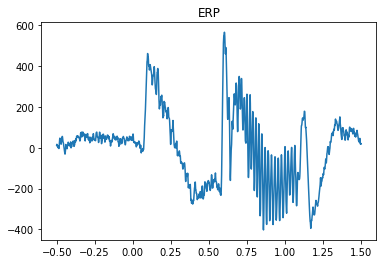

In [104]:
plt.plot(eeg_data['timevec'], erp)
plt.title('ERP')
plt.show()

In [105]:
## wavelet convolution

# initial parameters and time vector
fwhm = .2 # seconds
wavetime = np.arange(2*eeg_data['srate'])/eeg_data['srate']
wavetime = wavetime - np.mean(wavetime)
halfwave = int(np.floor(len(wavetime)/2)+1)

In [151]:
# compute convolution N's
nConv = len(eeg_data['timevec']) + len(wavetime) - 1

# create wavelet and compute its spectrum
cmw = np.exp( 1j*2*np.pi*42*wavetime ) * np.exp( -4*np.log(2)*wavetime**2 / fwhm**2 )
cmwX = fft(cmw,nConv)
cmwX = cmwX / np.max(cmwX)

In [107]:
# run convolution (multiplication of two spectra!!)
a = ifft(fft(erp, nConv) * cmwX)
a = a[halfwave-2:-halfwave+1]

cmw_amp = 2* np.abs(a)

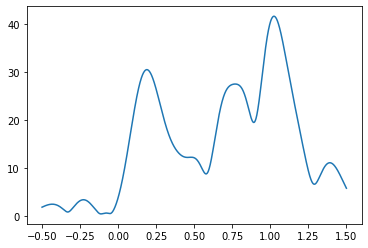

In [108]:
plt.plot(eeg_data['timevec'], cmw_amp)

In [135]:
## Create an FIR filter at 42 Hz

# create filter parameters
filter_width = 2.5 # ONE-SIDED hz
center_freq = 42

# fir1 parameters
fbounds = np.array([center_freq-filter_width, center_freq+filter_width ]) / (eeg_data['srate']/2)
order = 300

In [136]:
# create the filter kernel
filtkern = sp_signal.firwin(order,fbounds,pass_zero='bandpass')

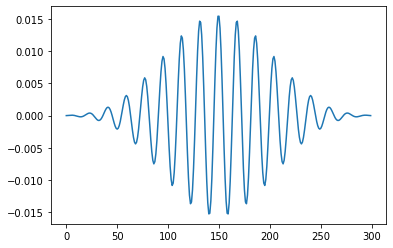

In [137]:
plt.plot(filtkern)

(100.0, 250.0)

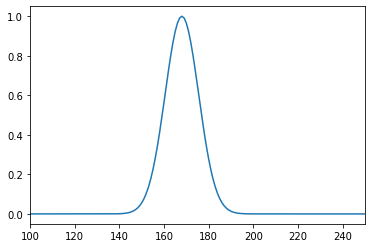

In [165]:
plt.plot(np.abs(cmwX))
plt.xlim([100,250])

(0.0, 40.0)

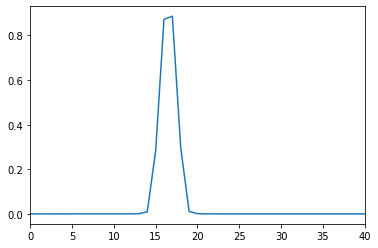

In [166]:
plt.plot(np.abs(fft(filtkern)))
plt.xlim([0,40])

In [139]:
# apply the filter
filtsig = sp_signal.filtfilt(filtkern,1,erp)

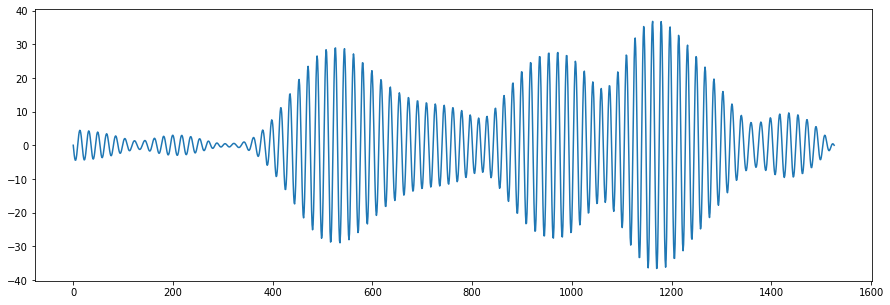

In [140]:
plt.figure(figsize=(15,5))
plt.plot(filtsig)

In [141]:
#extract amplitude time series using hilbert
fh_amp = np.abs(sp_signal.hilbert(filtsig))

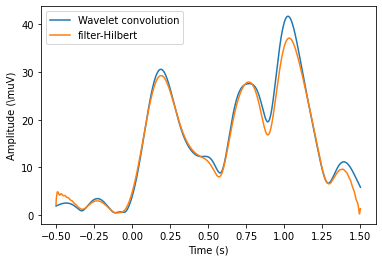

In [142]:
## plotting

plt.figure()
plt.plot(eeg_data['timevec'], cmw_amp, label='Wavelet convolution')
plt.plot(eeg_data['timevec'], fh_amp, label='filter-Hilbert')
# plt.xlim',timevec([1 end]))
# legend({'Wavelet convolution','filter-Hilbert'})
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (\muV)')
plt.legend()
# plt.title('The plot.')
plt.show()

## 5) Wavelet convolution for all channels and visualize with tfviewerx

So far, we've been doing time-frequency analysis one channel at a time. Now we will do it for all channels, and visualize the results using `tfviewerx`. Make sure to temporally downsample the results after convolution!

In [56]:
eeg_data = loadmat('../data/sampleEEGdata.mat')
data = eeg_data['EEG']['data'][0][0]
times = eeg_data['EEG']['times'][0][0][0]
srate = eeg_data['EEG']['srate'][0][0][0][0]

In [31]:
data.shape

(64, 640, 99)

In [30]:
times.shape

(640,)

In [54]:
# downsampled time points
times2save = np.arange(-250, 1251, 25)
times2save.shape

(61,)

In [55]:
tidx = []

for val in times2save:
    tidx.append(np.abs(times - val).argmin())
    
tidx = np.array(tidx)
tidx

array([192, 198, 205, 211, 218, 224, 230, 237, 243, 250, 256, 262, 269,
       275, 282, 288, 294, 301, 307, 314, 320, 326, 333, 339, 346, 352,
       358, 365, 371, 378, 384, 390, 397, 403, 410, 416, 422, 429, 435,
       442, 448, 454, 461, 467, 474, 480, 486, 493, 499, 506, 512, 518,
       525, 531, 538, 544, 550, 557, 563, 570, 576])

In [53]:
# baseline time boundaries
baseidx = []

for val in [-500, -200]:
    baseidx.append(np.abs(times - val).argmin())
    
baseidx = np.array(baseidx)
baseidx

array([128, 205])

In [67]:
## time-frequency analysis

# soft-coded parameters
freqrange = [2, 40] # extract only these frequencies (in Hz)
numfrex = 33 # number of frequencies between lowest and highest

# set up convolution parameters
wavtime = np.arange(-2, 2+1/srate, 1/srate)
frex = np.linspace(freqrange[0], freqrange[1],numfrex)
nKern = len(wavtime)
nConv = len(times)*data.shape[2] + nKern - 1
halfwav = int(round((len(wavtime)-1)/2))

# number of cycles
fwhms = np.linspace(.5,.2,numfrex)

In [62]:
#initialize TF matrix
tf = np.zeros((data.shape[0], numfrex, len(tidx)))

In [83]:
# get the spectrum of each channel (could do this in a loop)
dataX = fft(np.reshape(data, (data.shape[0],-1), 'F'), nConv, 1)
dataX.shape

(64, 64384)

In [93]:
# create wavelets and do TF decomposition in one loop

for fi in tqdm(range(numfrex)):
    
    # create time-domain wavelet
    cmw = np.exp(2*1j*np.pi*frex[fi]*wavtime) * np.exp( (-4*np.log(2)*wavtime**2) / fwhms[fi]**2 )
    
    # compute fourier coefficients of wavelet and normalize
    cmwX = fft(cmw,nConv)
    cmwX = cmwX / np.max(cmwX)
    
    # now loop over channels
    for chani in range(data.shape[0]):
        
        # Fourier spectrum of channel data
#         dataX = fft( np.reshape(data[chani, :, :], (1,-1), 'F'),nConv)
        
        # second and third steps of convolution
        a = ifft( dataX[chani,:] *cmwX )
        
        # cut wavelet back to size of data
        a = a[halfwav:-halfwav]
        a = 2*np.reshape(a, (data.shape[1], data.shape[2]), 'F') / data.shape[1]
        
        # power time series
        powts = np.mean( np.abs(a)**2, 1)
        
        # baseline-normalized power time series
        # only from down-sampled time points!
        tf[chani,fi,:] = 10*np.log10( powts[tidx] / np.mean(powts[baseidx[0]:baseidx[1]]) )
        

100%|██████████| 33/33 [00:34<00:00,  1.05s/it]


In [89]:
tf.shape

(64, 33, 61)

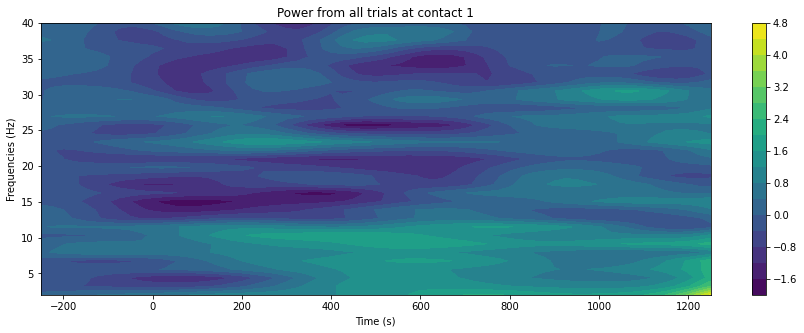

In [101]:
chan2plot = 1

plt.figure(figsize=(15,5))

plt.contourf(times2save, frex, tf[chan2plot, :, :], 20)
plt.xlabel('Time (s)')
plt.ylabel('Frequencies (Hz)')
plt.title(f'Power from all trials at contact {chan2plot}')
plt.colorbar()
# plt.xlim([-.2, 1])
# plt.clim([0, 80000])

plt.show()

## 6) compare wavelet convolution and mean over time with static FFT

Adjust the code from the previous exercise to save the static spectrum without baseline normalization. Then implement a static FFT (like what you learned in the previous section of the course) to get power from one electrode.

Compare the static power spectrum and the time-averaged TF power spectrum on the same graph.